In [1]:
import pandas as pd

CK_groups_df = pd.read_csv("E:/680_temp3.18DID/2009-2016/processed/processed_data_2008.csv")
state_panels2008_df = pd.read_csv("E:/680_temp3.18DID/2009-2016/year/data_year_2008.csv")

T_df = pd.read_csv("E:/680_temp3.18DID/processed_VZ_mw_data.csv" )
T_df = T_df.rename(columns={'statefips': 'statenum'})
T_df_2008 = T_df[T_df['year'] == 2008]
# 合并数据集
# 第一步：合并 CK_groups_df 和 state_panels2008_df
df_merged_step1 = pd.merge(CK_groups_df, state_panels2008_df, on=["statenum", "quarterdate"], how="inner")

# 第二步：将上一步的合并结果与 T_df 进行合并
df_merged_final = pd.merge(df_merged_step1, T_df_2008, on=["statenum", "quarterdate"], how="inner")



In [2]:
# 假设df_merged已经是通过某种方式合并了'CK_groups.dta'和'state_panels_with3quant1979.dta'的DataFrame
# 以下是根据实际提供的变量名称来定义X, T, Y

# 定义特征变量（X）
# 可以包括年份、季度和人口统计特征等
# 这里选择了quarterdate（可能需要从中提取年份和季度）、州编号（statenum）和一些人口统计特征作为例子
X = df_merged_final[['blackpop', 'whitepop', 'genderpop', 'teenpop']]

# 处理变量（T）
# 假设'MW_real'代表了实际的最低工资水平，我们可以将其变化（例如提升）作为处理
# 这需要一些额外的处理来确定哪些观察值是在最低工资提升后的，但基于描述，我们直接用'MW_real'示例
# 在实际应用中，可能需要创建一个表示政策变化的变量
T = df_merged_final['T']  # 这里假设'MW_real'直接用作处理变量，实际上可能需要根据最低工资的变化创建一个新变量

# 结果变量（Y）
# 假设'employment_rate'（就业率）或'emp'（就业人数）作为结果变量
# 这里使用'emp'作为结果变量的例子
Y = df_merged_final['avewage']

# 注意：这个示例代码是基于提供的变量名简化构建的，实际应用中可能需要根据最低工资的具体变化来创建处理变量（T）



In [4]:
print(CK_groups_df[['statenum', 'quarterdate']].drop_duplicates().shape)
print(state_panels2008_df[['statenum', 'quarterdate']].drop_duplicates().shape)
print(T_df_2008[['statenum', 'quarterdate']].drop_duplicates().shape)


(204, 2)
(204, 2)
(204, 2)


In [5]:
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor

# 初始化因果随机森林模型
crf = CausalForestDML(model_y=GradientBoostingRegressor(), 
                      model_t=GradientBoostingRegressor(),
                      criterion='mse', n_estimators=100, 
                      min_samples_leaf=10, 
                      max_depth=None)

# 假设 X, T, Y 已经准备好，并且是正确的格式
# 拟合模型
# 注意：fit方法的调用需要遵循你使用的econml版本的要求，下面的调用适用于大多数情况
crf.fit(Y, T, X=X, W=None, inference='auto')

# 估计因果效应
treatment_effects = crf.effect(X)


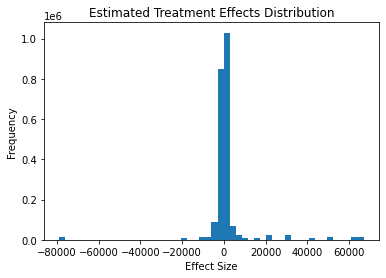

In [6]:
import matplotlib.pyplot as plt

# 绘制因果效应分布
plt.hist(treatment_effects, bins=50)
plt.title('Estimated Treatment Effects Distribution')
plt.xlabel('Effect Size')
plt.ylabel('Frequency')
plt.show()

# 获取置信区间
te_lower, te_upper = crf.effect_interval(X, alpha=0.05)

# 可以进一步分析不同子群体的影响或将效应大小映射回原始数据集进行深入分析。
